In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2
import emcee
from cmdstanpy import CmdStanModel

In [8]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = 0.001
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard/sum(hazard), survival[:-1]

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.01
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [9]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


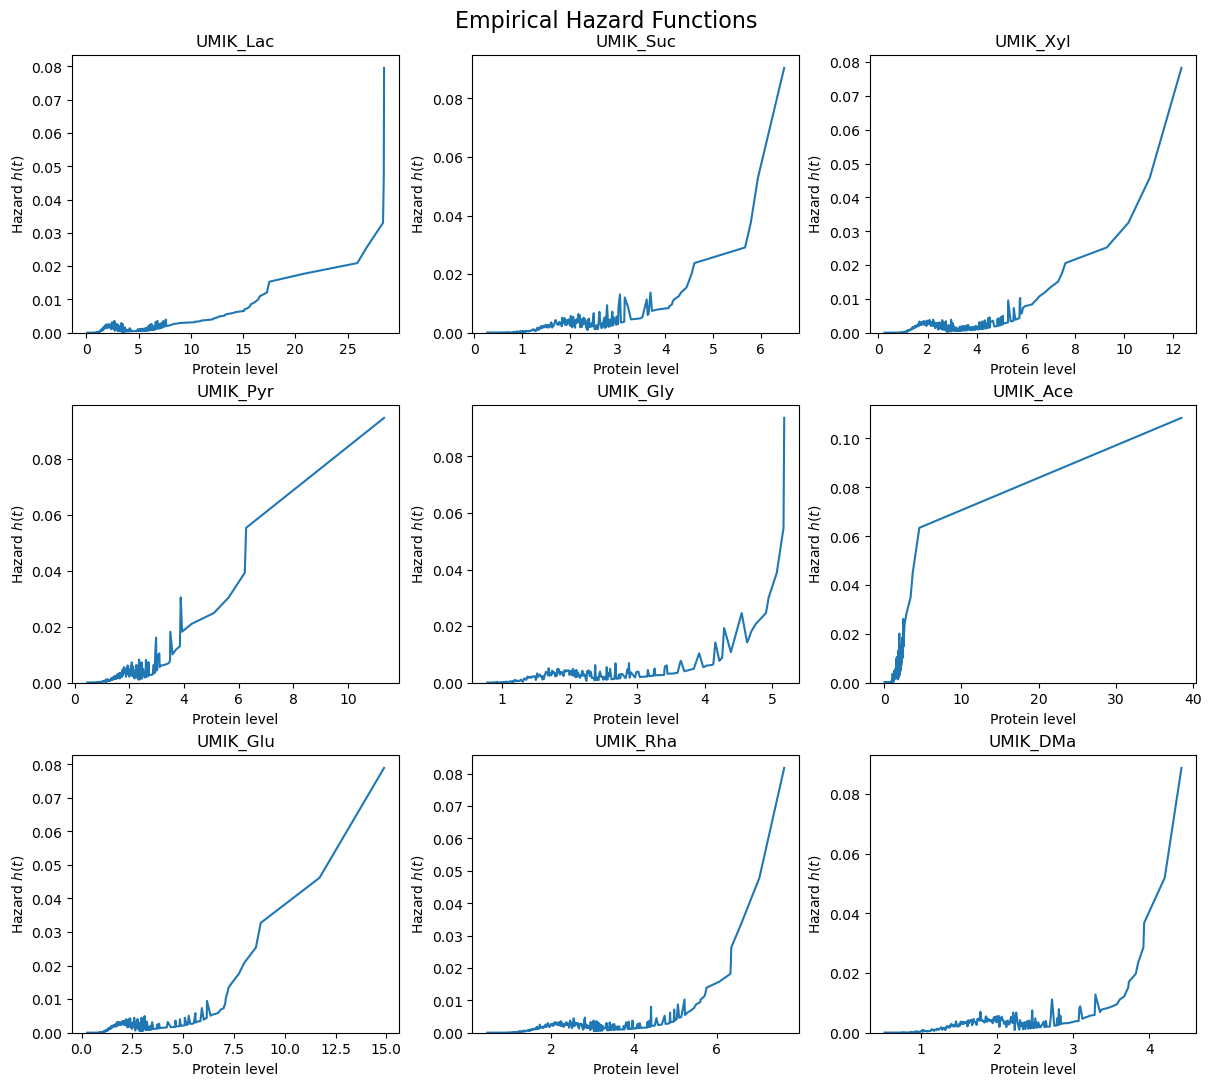

In [10]:
hazards = []                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [11]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{\left( \frac{p}{\tau} \right)^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_42604/2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


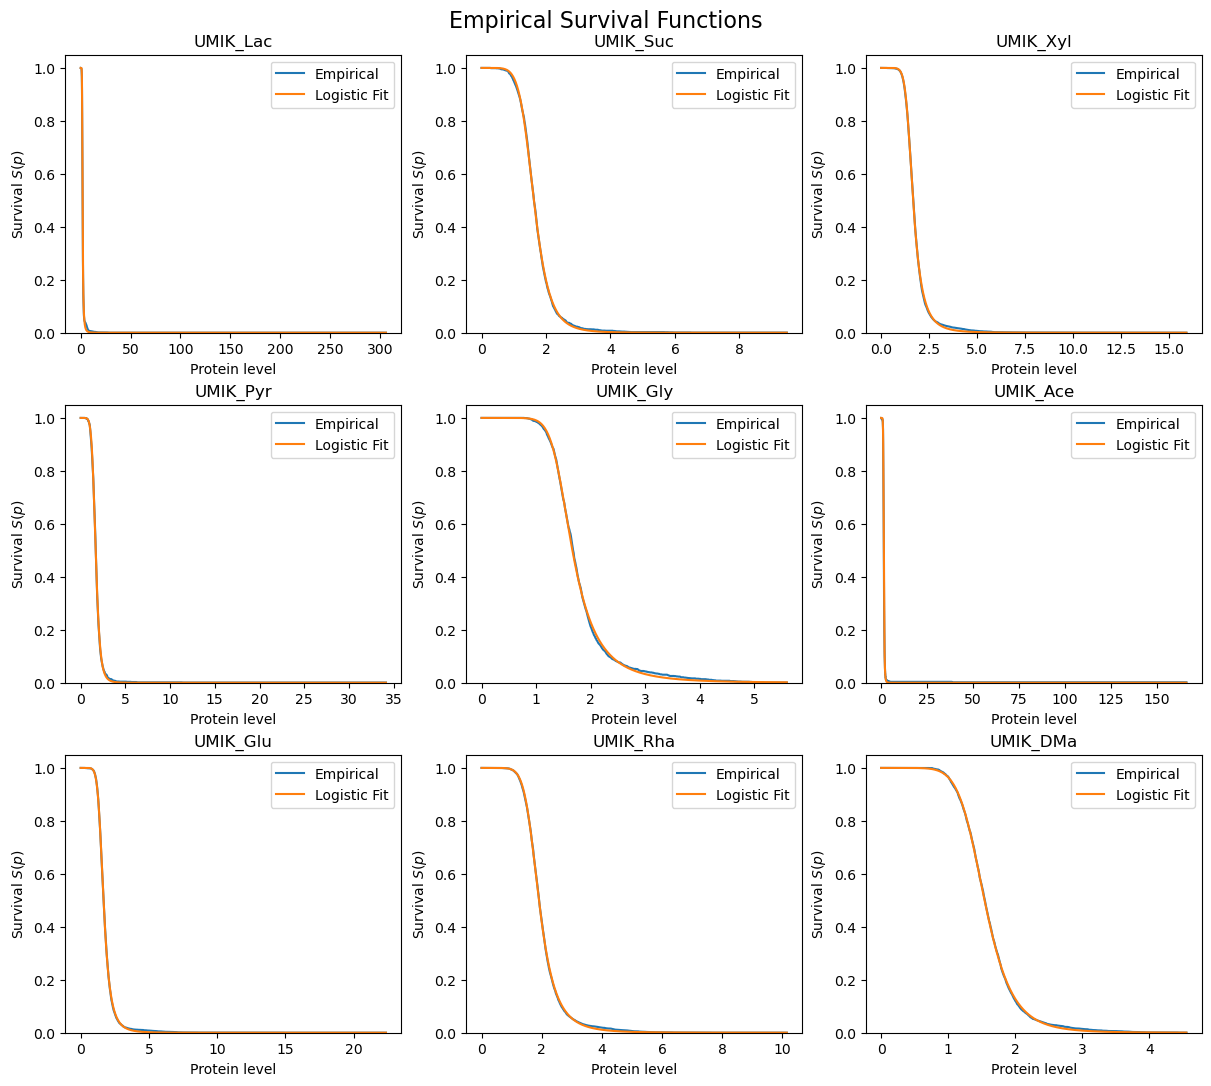

In [12]:
hazards = []                         

for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["T", "k", "a"]

In [26]:
fittingParams

,T,k,a
0,1.597620,9.063562,0.402818
1,1.627688,6.695966,1.008939
2,1.503213,9.204902,0.543990
3,1.696184,6.879143,1.061840
4,1.486226,9.994281,0.487794
5,1.433339,8.987700,0.845285
6,1.545813,8.273218,0.643941
7,1.777104,8.197598,0.675169
8,1.520874,7.688450,0.926811


In [27]:
fittingParams['T'][8]

1.5208737752313588

Text(0.5, 1.0, 'Fitting parameters')

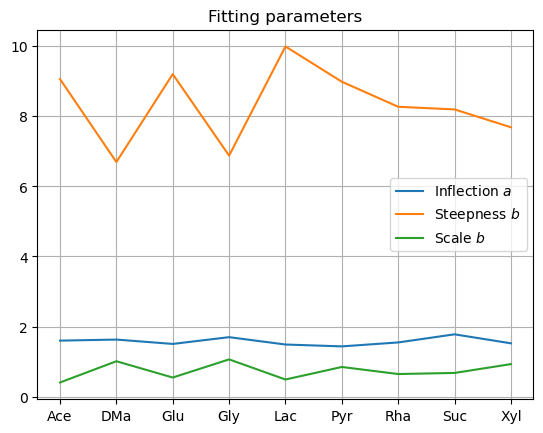

In [13]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

plt.plot(fittingParams["T"], label ='Inflection $a$')
plt.plot(fittingParams["k"], label ='Steepness $b$')
plt.plot(fittingParams["a"], label ='Scale $b$')

plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels = sugars)
plt.title("Fitting parameters")

Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters T - k')

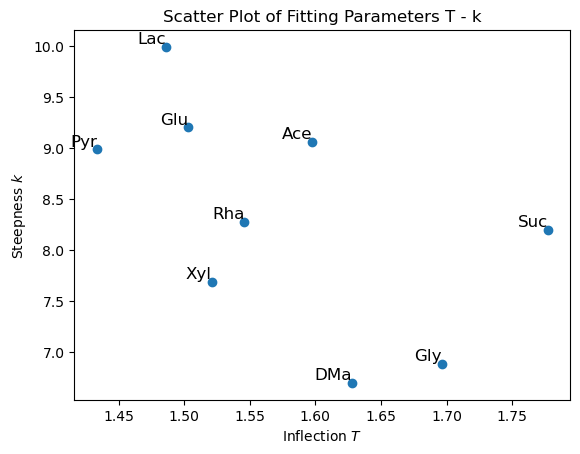

In [14]:
T = fittingParams["T"]
k = fittingParams["k"]
a = fittingParams["a"]

plt.scatter(T,k)
for i, label in enumerate(sugars):
    plt.text(T[i], k[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Inflection $T$')
plt.ylabel('Steepness $k$')
plt.title('Scatter Plot of Fitting Parameters T - k')

# Hazard function from survial fit (DMa)

In [15]:
grid = hazards[1][1]
h = hazards[1][2]
survival = hazards[1][3]

In [16]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))
survival_fit = generalized_logistic_survival(grid_fit, *popt)

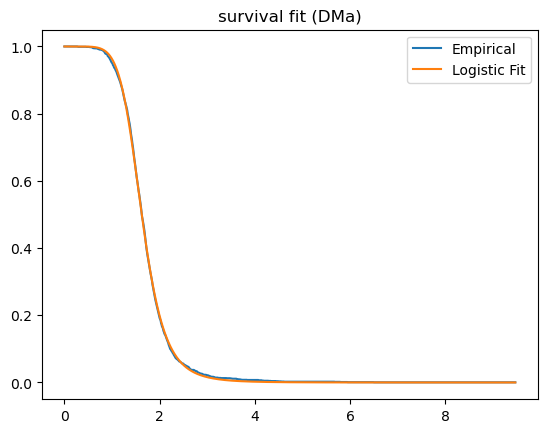

In [17]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [18]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

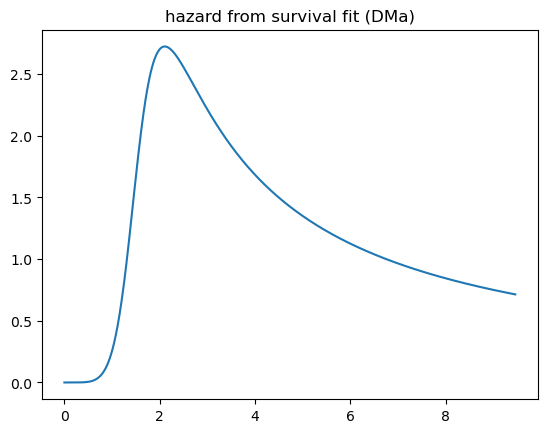

In [19]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [20]:
u = grid_fit

log_l_vals=np.empty(u.shape[0])

for i,u_i in enumerate(u):
    params_val = [u_i ,v_true,omega2_true,alpha2_true,beta2_true,alpha1_true,scale1_true]
    log_l_vals[i]=model2.log_likelihood(params_val,initial_mass,lineagest,timest,alphast,fst)


plt.plot(u,log_l_vals ,lw=2, ls='dashed', color='blue',  label='')
plt.title("Likelihood with u variable")
plt.ylabel(" log(likelihood) value")
plt.xlabel(" u value")
plt.show()
print("True values:", initial_values)

NameError: name 'v_true' is not defined

In [21]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


In [22]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



### Sampling with determistic parameters

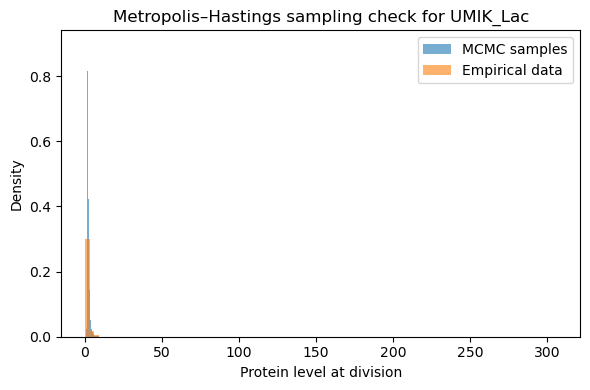

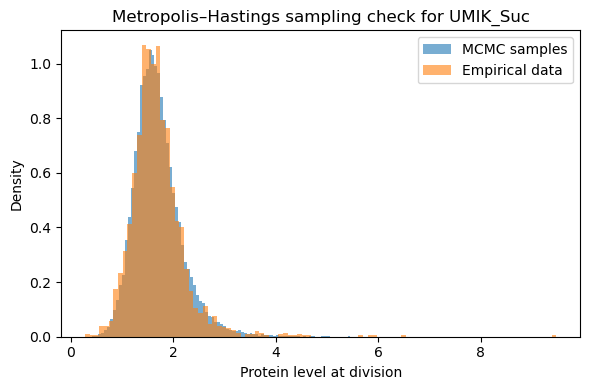

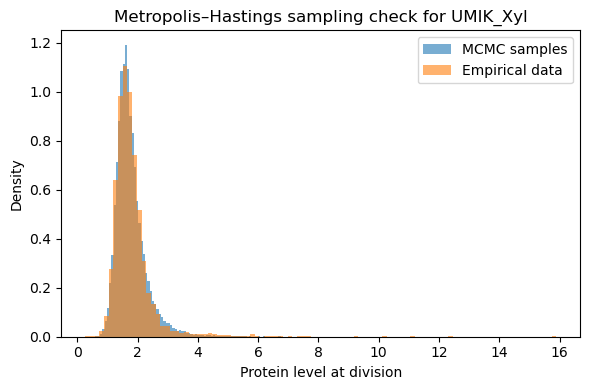

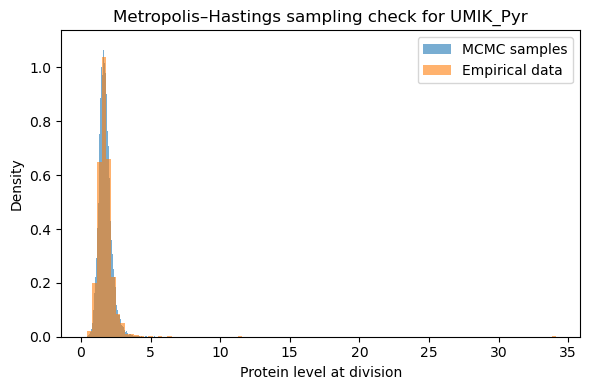

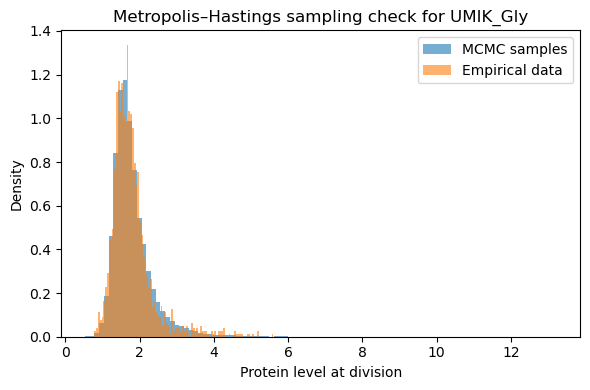

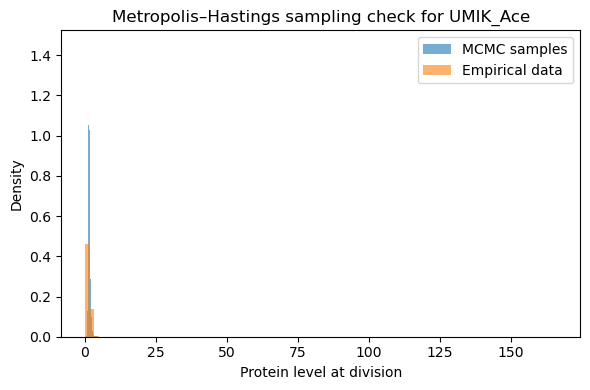

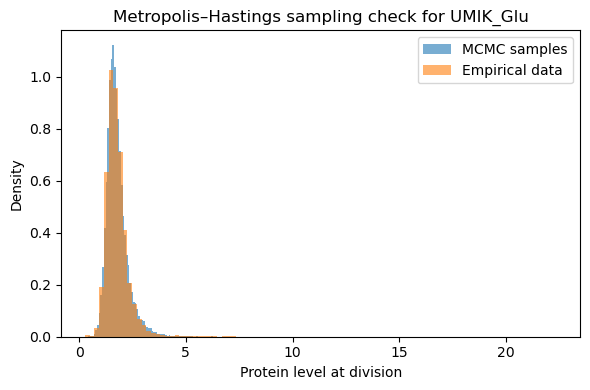

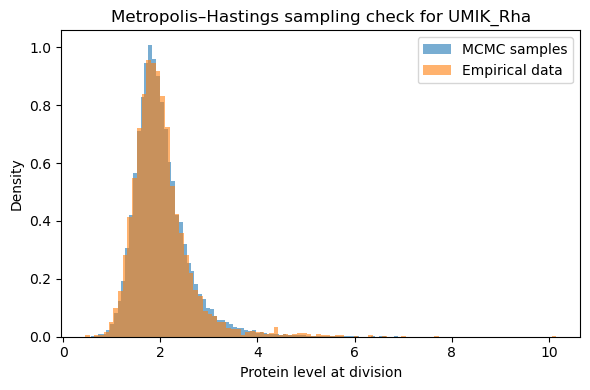

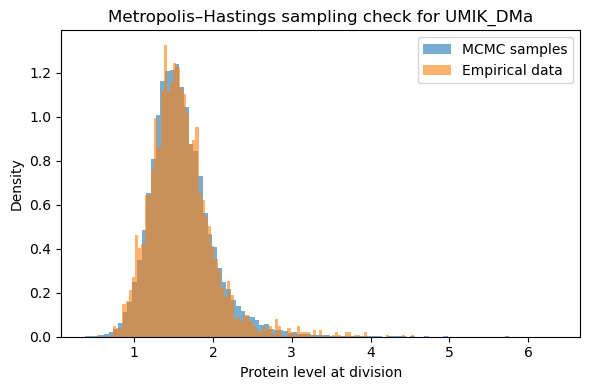

In [23]:
for i in range(len(fittingParams['a'])):
    alpha, k, tau = fittingParams['a'][i], fittingParams['k'][i] , fittingParams['T'][i]
    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)

    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"]
    plt.figure(figsize=(6, 4))
    plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    plt.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Metropolis–Hastings sampling check for {names[i]}")
    plt.legend()
    plt.tight_layout()

In [81]:

stan_model_code = """
functions {
  real log_protein_pdf(real p, real alpha, real k, real tau) {
    return log(alpha)
         + log(k)
         - k * log(tau)
         + (k - 1) * log(p)
         - (alpha + 1) * log1p(pow(p / tau, k));
  }
}
data {
  int<lower=1> N;
  vector<lower=1e-8>[N] p;
}
parameters {
  real<lower=1e-6, upper=1e6> alpha;
  real<lower=1e-6, upper=1e6> k;
  real<lower=1e-6, upper=1e6> tau;
}
model {
  for (n in 1:N)
    target += log_protein_pdf(p[n], alpha, k, tau);
}
"""

In [74]:
with open("protein_model.stan", "w") as f:
    f.write(stan_model_code)


In [75]:
model = CmdStanModel(stan_file="protein_model.stan")

21:07:51 - cmdstanpy - INFO - compiling stan file /var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/tmpy4vprtfw/tmp71d8tgpd.stan to exe file /Users/test/Desktop/Master semester 2/LCP B/PoD_microbial_growth/Code/PoD_microbial_growth_repo/protein_model
21:07:59 - cmdstanpy - INFO - compiled model executable: /Users/test/Desktop/Master semester 2/LCP B/PoD_microbial_growth/Code/PoD_microbial_growth_repo/protein_model


In [82]:
n_walkers = 12       # ≥2×dim
ndim      = 3
init_pos  = np.random.randn(n_walkers, ndim)  

samples_dict = {}
for name in names:
    protein_levels = dfs[name]["protein_level"].dropna().values
    protein_levels = protein_levels[protein_levels > 0] 

    stan_data = {
        "N": len(protein_levels),
        "p": protein_levels
    }

    # write Stan code to a file
    with open("protein_model.stan", "w") as f:
        f.write(stan_model_code)   # assume `stan_model_code` holds the model string

    # compile and sample
    fit = model.sample(data=stan_data, chains=4, iter_sampling=2000, iter_warmup=1000)

    # extract posterior samples
    samples = fit.draws_pd()
    print(samples.head())

    # store samples in the dictionary
    samples_dict[name] = samples[["alpha", "k", "tau"]]

21:22:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:50 - cmdstanpy - INFO - CmdStan done processing.
21:25:50 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -6010.76       0.999284    0.044694          2.0   
1      1.0     2.0     2.0 -6009.18       0.998399    0.044694          3.0   
2      1.0     3.0     3.0 -6008.94       0.857690    0.044694          2.0   
3      1.0     4.0     4.0 -6010.45       0.891227    0.044694          2.0   
4      1.0     5.0     5.0 -6010.56       0.989920    0.044694          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           7.0          0.0   6011.90  0.436903  7.93838  1.61591  
1           7.0          0.0   6011.25  0.451113  8.08297  1.62091  
2           7.0          0.0   6010.83  0.447237  8.00368  1.62729  
3           7.0          0.0   6011.12  0.440850  7.98174  1.62578  
4           7.0          0.0   6011.30  0.436319  8.02887  1.62262  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:21 - cmdstanpy - INFO - CmdStan done processing.
21:29:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
21:29:21 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -1334.23       0.939835    0.227493          3.0   
1      1.0     2.0     2.0 -1334.62       0.918559    0.227493          4.0   
2      1.0     3.0     3.0 -1334.55       0.942148    0.227493          3.0   
3      1.0     4.0     4.0 -1334.24       0.986713    0.227493          3.0   
4      1.0     5.0     5.0 -1335.13       0.941729    0.227493          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           7.0          0.0   1336.95  1.096870  6.22698  1.65535  
1          15.0          0.0   1336.45  1.063220  6.20222  1.64170  
2           7.0          0.0   1335.85  1.030490  6.23729  1.63554  
3          15.0          0.0   1335.79  0.964907  6.73627  1.61832  
4           7.0          0.0   1335.41  0.930171  6.50080  1.58704  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:31 - cmdstanpy - INFO - CmdStan done processing.
21:45:31 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -4317.49       0.683390    0.001642          1.0   
1      1.0     2.0     2.0 -4317.32       0.987091    0.001642          2.0   
2      1.0     3.0     3.0 -4322.27       0.937783    0.001642          4.0   
3      1.0     4.0     4.0 -4321.26       0.939699    0.001642          2.0   
4      1.0     5.0     5.0 -4316.92       0.998526    0.001642          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           3.0          0.0   4317.77  0.505986  9.42533  1.47862  
1           7.0          0.0   4319.03  0.491413  9.41994  1.48010  
2          15.0          0.0   4322.63  0.535878  9.41951  1.50723  
3           3.0          0.0   4323.43  0.529580  9.41748  1.50636  
4          15.0          0.0   4322.96  0.507583  9.43379  1.48164  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:08 - cmdstanpy - INFO - CmdStan done processing.
21:47:08 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -913.308       0.948428    0.210899          2.0   
1      1.0     2.0     2.0 -915.198       0.993488    0.210899          5.0   
2      1.0     3.0     3.0 -914.758       1.000000    0.210899          2.0   
3      1.0     4.0     4.0 -913.318       0.983547    0.210899          2.0   
4      1.0     5.0     5.0 -914.348       0.984628    0.210899          4.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           7.0          0.0   913.802  0.924905  7.08916  1.66494  
1          31.0          0.0   915.555  1.062130  6.58566  1.68130  
2           3.0          0.0   915.474  1.003420  6.59098  1.68982  
3           7.0          0.0   916.873  1.020690  6.86718  1.68438  
4          15.0          0.0   915.557  1.068650  6.58810  1.69835  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:51:35 - cmdstanpy - INFO - CmdStan done processing.
21:51:35 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -1451.22       0.978356    0.037711          6.0   
1      1.0     2.0     2.0 -1451.45       0.743685    0.037711          6.0   
2      1.0     3.0     3.0 -1451.38       0.937711    0.037711          7.0   
3      1.0     4.0     4.0 -1451.28       0.969074    0.037711          6.0   
4      1.0     5.0     5.0 -1451.02       0.307394    0.037711          6.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0         127.0          0.0   1452.82  515852.0  2.89638  186.982  
1         127.0          0.0   1453.71  825405.0  2.89793  218.782  
2         143.0          0.0   1453.42  453453.0  2.99539  154.263  
3         127.0          0.0   1451.99  289922.0  2.97375  137.091  
4          77.0          0.0   1453.75  329064.0  2.96174  145.457  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:14 - cmdstanpy - INFO - CmdStan done processing.
21:52:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 49 divergent transitions (2.5%)
	Chain 3 had 20 divergent transitions (1.0%)
	Chain 4 had 66 divergent transitions (3.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
21:52:14 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -940.259       0.994396    0.070773          4.0   
1      1.0     2.0     2.0 -938.379       0.940053    0.070773          6.0   
2      1.0     3.0     3.0 -939.372       0.999157    0.070773          5.0   
3      1.0     4.0     4.0 -939.807       0.438674    0.070773          6.0   
4      1.0     5.0     5.0 -939.258       0.920190    0.070773          5.0   

   n_leapfrog__  divergent__  energy__     alpha        k       tau  
0          31.0          0.0   942.012  845668.0  1.04735  908045.0  
1          63.0          0.0   940.409  609435.0  1.05431  594369.0  
2          31.0          0.0   940.079  775265.0  1.06395  660888.0  
3          63.0          0.0   940.837  859443.0  1.06138  762141.0  
4          35.0          0.0   942.870  593932.0  1.02025  814790.0  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:03:10 - cmdstanpy - INFO - CmdStan done processing.
22:03:10 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -4084.70       0.531958    0.001111          2.0   
1      1.0     2.0     2.0 -4085.04       0.975208    0.001111          3.0   
2      1.0     3.0     3.0 -4085.74       0.986973    0.001111          3.0   
3      1.0     4.0     4.0 -4085.23       0.842215    0.001111          2.0   
4      1.0     5.0     5.0 -4084.84       0.999980    0.001111          4.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           3.0          0.0   4087.63  0.592809  8.39344  1.52691  
1           7.0          0.0   4085.09  0.614816  8.39011  1.52728  
2           7.0          0.0   4086.56  0.622789  8.38917  1.53172  
3           7.0          0.0   4089.73  0.583004  8.39235  1.51692  
4          15.0          0.0   4085.47  0.586276  8.38949  1.51803  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:15:51 - cmdstanpy - INFO - CmdStan done processing.
22:15:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 3 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
22:15:51 - cmdstanpy - INFO - CmdStan start processing



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -3535.89       1.000000    0.279393          1.0   
1      1.0     2.0     2.0 -3536.64       0.868366    0.279393          2.0   
2      1.0     3.0     3.0 -3537.80       0.891345    0.279393          3.0   
3      1.0     4.0     4.0 -3541.15       0.874783    0.279393          2.0   
4      1.0     5.0     5.0 -3538.10       1.000000    0.279393          3.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0           1.0          0.0   3536.28  0.667255  7.93441  1.76894  
1           3.0          0.0   3537.20  0.677018  7.95577  1.76450  
2          15.0          0.0   3539.91  0.636950  8.32549  1.77422  
3           3.0          0.0   3542.60  0.672774  8.46592  1.77232  
4           7.0          0.0   3540.75  0.661581  8.44454  1.77370  


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:22:05 - cmdstanpy - INFO - CmdStan done processing.



   chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -1518.15       0.968258    0.004089          8.0   
1      1.0     2.0     2.0 -1518.20       0.996254    0.004089          5.0   
2      1.0     3.0     3.0 -1518.35       0.973075    0.004089          5.0   
3      1.0     4.0     4.0 -1518.13       0.998753    0.004089          4.0   
4      1.0     5.0     5.0 -1518.25       0.999752    0.004089          7.0   

   n_leapfrog__  divergent__  energy__     alpha        k      tau  
0         447.0          0.0   1519.33  536025.0  3.52439  74.4573  
1          55.0          0.0   1518.55  533552.0  3.55459  71.6531  
2          43.0          0.0   1518.70  541875.0  3.54129  72.7974  
3          19.0          0.0   1518.41  544665.0  3.54801  72.9982  
4         255.0          0.0   1518.46  634146.0  3.50253  79.7451  


In [83]:
print(samples_dict)

{'UMIK_Lac':          alpha        k      tau
0     0.436903  7.93838  1.61591
1     0.451113  8.08297  1.62091
2     0.447237  8.00368  1.62729
3     0.440850  7.98174  1.62578
4     0.436319  8.02887  1.62262
...        ...      ...      ...
7995  0.455262  8.09049  1.62745
7996  0.434646  8.01301  1.61111
7997  0.440544  8.16284  1.61218
7998  0.436106  8.01563  1.61480
7999  0.445145  8.04641  1.60728

[8000 rows x 3 columns], 'UMIK_Suc':          alpha        k      tau
0     1.096870  6.22698  1.65535
1     1.063220  6.20222  1.64170
2     1.030490  6.23729  1.63554
3     0.964907  6.73627  1.61832
4     0.930171  6.50080  1.58704
...        ...      ...      ...
7995  0.948869  6.61882  1.60220
7996  0.933868  6.62330  1.60498
7997  1.102380  6.16980  1.65526
7998  1.101690  6.16786  1.67099
7999  1.034640  6.60595  1.65137

[8000 rows x 3 columns], 'UMIK_Xyl':          alpha        k      tau
0     0.505986  9.42533  1.47862
1     0.491413  9.41994  1.48010
2     0.535878  9.41

In [26]:
def log_protein_levels_pdf(p, alpha, k, tau):
    if p <= 0 or alpha <= 0 or k <= 0 or tau <= 0:
        return -np.inf

    try:
        logf = (
            np.log(alpha) +
            np.log(k) -
            k * np.log(tau) +
            (k - 1) * np.log(p) -
            (alpha + 1) * np.log1p((p / tau)**k)
        )
        return logf
    except:
        return -np.inf
    
def protein_levels_at_division_pdf(p, alpha, k, tau):
    log_val = log_protein_levels_pdf(p, alpha, k, tau)
    return np.exp(log_val) if np.isfinite(log_val) else 0

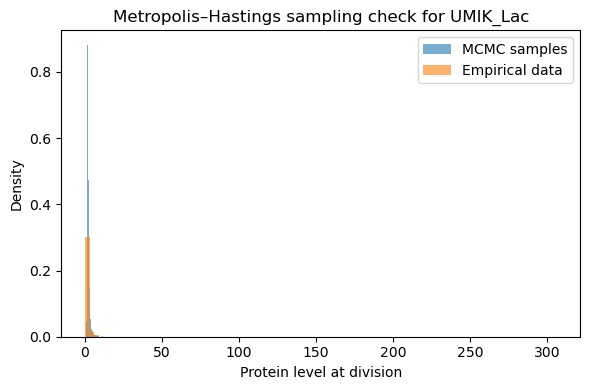

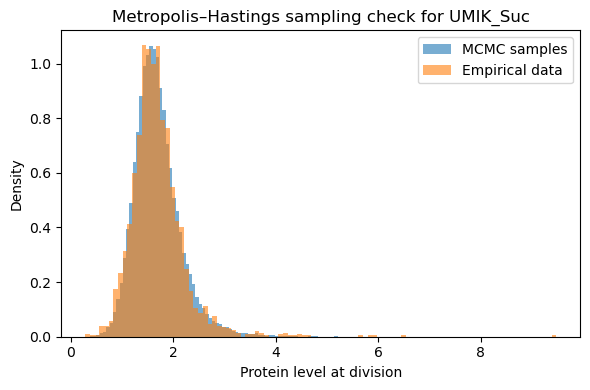

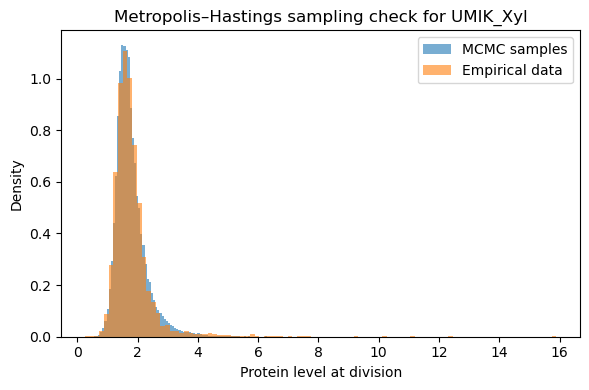

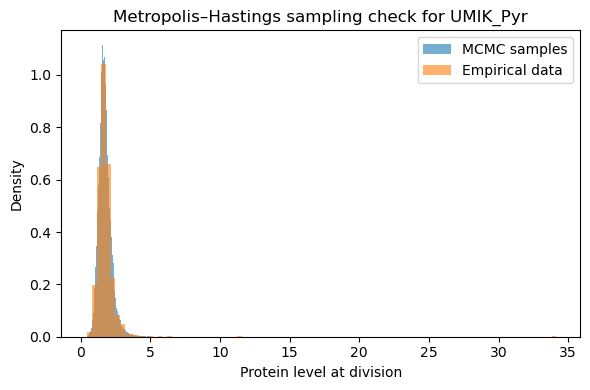

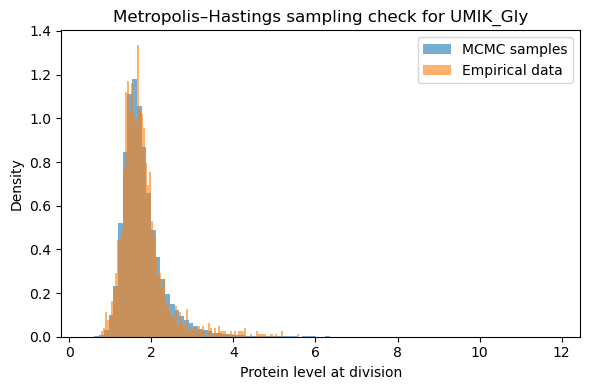

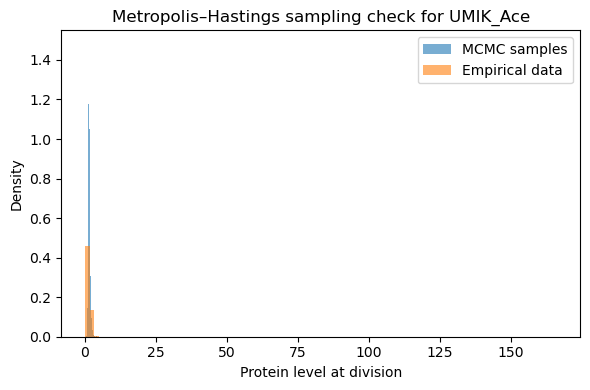

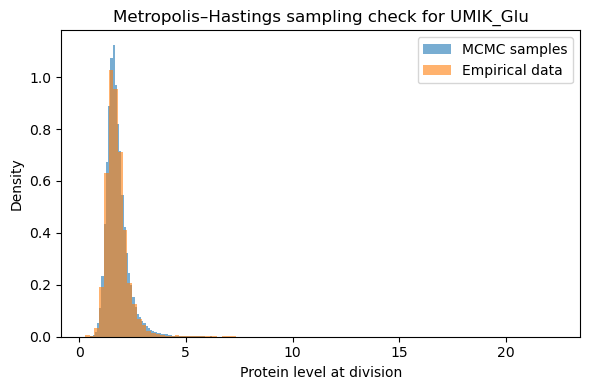

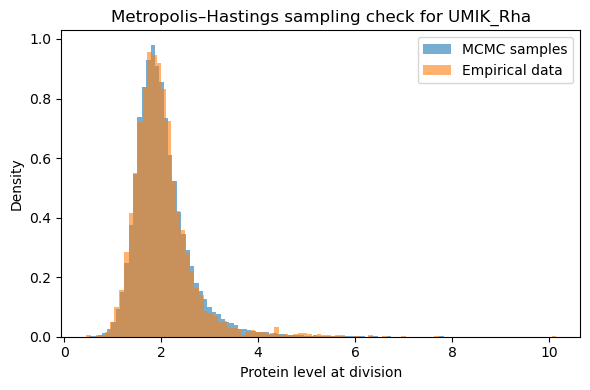

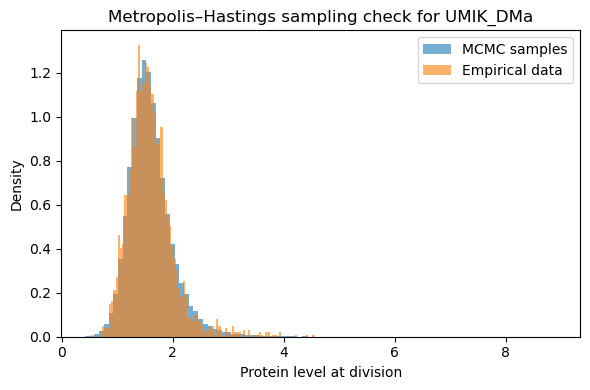

In [27]:
for i in range(len(fittingParams['a'])):
    alpha, k, tau = fittingParams['a'][i], fittingParams['k'][i] , fittingParams['T'][i]
    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)

    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"]
    plt.figure(figsize=(6, 4))
    plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    plt.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Metropolis–Hastings sampling check for {names[i]}")
    plt.legend()
    plt.tight_layout()

In [28]:
for i in range(len(names)):
    # Extract posterior samples (e.g. from Stan or emcee output)
    posterior_df = samples_dict[names[i]]     # shape (n_draws, 3)
    alphas = posterior_df["alpha"].sample(100)
    print("alphas:", alphas)
    ks = posterior_df["k"].sample(100)
    print("ks:", ks)
    taus = posterior_df["tau"].sample(100)
    print("taus:", taus)
    simulated = []
    # For each posterior draw, simulate a protein level
    for alpha, k, tau in zip(alphas, ks, taus):
        # sample one value using your MCMC kernel
        sample = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau, n_samples=1_000)
        print("sample:", sample)
        simulated.extend(sample)

    simulated = np.array(simulated)
    #print(simulated)
    empirical_protein_level = dfs[names[i]]["protein_level"].dropna().values

    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(simulated, bins=100, density=True, alpha=0.6, label="Posterior Predictive", color='C0')
    plt.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical Data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Posterior Predictive Check — {names[i]}")
    plt.legend()
    plt.tight_layout()
    print(i)
    plt.show()
    

NameError: name 'samples_dict' is not defined

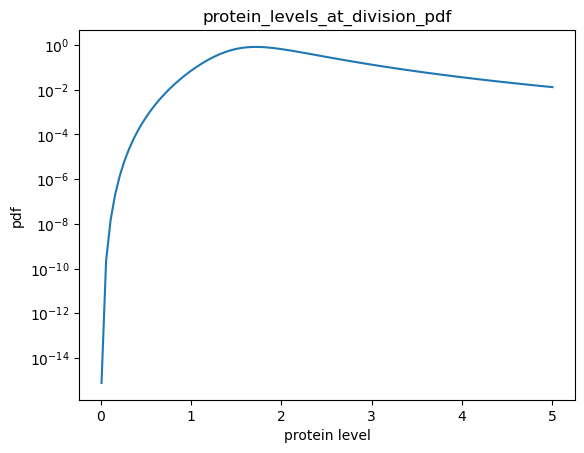

In [92]:
alpha = alphas.iloc[0]
k = ks.iloc[0]
tau = taus.iloc[0]

x_vals = np.linspace(0.01, 5, 100)
y_vals = [protein_levels_at_division_pdf(x, alpha, k, tau) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.yscale('log')
plt.title("protein_levels_at_division_pdf")
plt.xlabel("protein level")
plt.ylabel("pdf")
plt.show()

### Superimposing the empirical calculation with the fit